In [ ]:
 !pip install pydlm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 1.5 MB/s eta 0:00:00


In [ ]:
import math
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.preprocessing import RobustScaler
from keras.models import Sequential
from pydlm import dlm, trend, seasonality, dynamic
from keras.layers import Dense
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error, mean_squared_error

In [57]:
data = pd.read_csv('TSLA.csv')

In [58]:
data.corr().style.format("{:.5}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

<ipython-input-58-0ec218d4fe38>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr().style.format("{:.5}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)


,Open,High,Low,Close,Adj Close,Volume
Open,1.0,0.99971,0.9996,0.99917,0.99917,0.025009
High,0.99971,1.0,0.99961,0.99963,0.99963,0.028913
Low,0.9996,0.99961,1.0,0.99967,0.99967,0.021347
Close,0.99917,0.99963,0.99967,1.0,1.0,0.02598
Adj Close,0.99917,0.99963,0.99967,1.0,1.0,0.02598
Volume,0.025009,0.028913,0.021347,0.02598,0.02598,1.0


In [59]:
df = pd.DataFrame(data)

In [60]:
df = df[['Close','High']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

In [79]:
train_size = int(0.6 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [80]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

In [81]:
from pydlm import dlm, trend, autoReg, dynamic

# Assuming train_data and y_train are already defined

high_feature = []
for price in train_data['High']:
    high_feature.append([price])

# Define the DLM model
myDLM = dlm(y_train)

# Add a linear trend component with prior covariance 1.0
myDLM = myDLM + trend(1, name='lineTrend', w=1.0)

# Add an autoregressive component with a prior covariance of 1e7
myDLM = myDLM + autoReg(degree=1, data=y_train, name='ar1', w=1e7)

# Add a dynamic component with the high_feature
myDLM = myDLM + dynamic(features=high_feature, discount=1, name='High')

# Fit the DLM model
myDLM.fit()

# Print the fitted model
print(myDLM)

/usr/local/lib/python3.10/dist-packages/pydlm/modeler/autoReg.py:75: UserWarning: The data argument in autoReg is deprecated. Please avoid using it.
  warn('The data argument in autoReg is deprecated. Please avoid using it.')


Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


In [82]:
# Quá trình testing, and predict test
x_test= []
for price in test_data['High']:
  x_test.append([price])
print(np.array(x_test).shape)
y_test = np.array(test_data['Close'])
y_test_pred = myDLM.predictN(date = myDLM.n-1, N=len(x_test),featureDict={'High': x_test})
y_test_pred = y_test_pred[0]

(600, 1)


In [83]:
mae = mean_absolute_error(y_test, y_test_pred)
mape = mean_absolute_percentage_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)

print("MAE:", mae)
print("MAPE:", mape * 100)
print("RMSE:", rmse)

MAE: 9.1972726195708
MAPE: 6.843225038625519
RMSE: 13.851926979423675


In [84]:
#Quá trình validate, and predict val
y_val = np.array(val_data['High'])
x_val= []
for price in val_data['High']:
  x_val.append([price])
print(type(x_val))
size = test_size + val_size
y_pred_val = myDLM.predictN(featureDict={'High': x_val}, N = len(x_val))
y_pred_val = y_pred_val[0]
print(y_pred_val)

<class 'list'>
[245.66952488785276, 176.21638373539724, 196.84001252472734, 185.4085715102873, 196.24654761304052, 192.23813818040392, 189.16720235079768, 200.8962136601636, 202.43709885167831, 212.98868546562315, 208.09831938333713, 210.46889584247307, 208.25365155627344, 207.21525160628158, 208.55501980794378, 207.22694833295094, 207.11586911069156, 210.01164979341073, 211.77608999182758, 203.5816106445203, 193.0440917457773, 204.27485882018573, 197.3244784333539, 201.5851547831118, 207.76144197976222, 207.000741031316, 207.89784351776905, 207.03382419944052, 207.15694138387846, 213.12190492613928, 214.78920752940195, 214.87396657741425, 214.46915790427386, 211.9858278860112, 222.58695922649903, 220.88328245379918, 220.5367225660785, 220.83990413979882, 214.06409335067218, 219.81147645911017, 218.92186782262644, 219.97158903796065, 220.44737520539525, 213.1641342126548, 216.46361098203772, 218.7884852849885, 219.767086928919, 225.69059817205022, 232.92389918133028, 229.41555815066042

In [85]:
# Thực hiện dự đoán 30 ngày tiếp theo của feature 'High' dựa trên Linear Regression
from sklearn.linear_model import LinearRegression
LR_model = LinearRegression()
LR_model.fit(np.array(train_data.index).reshape(-1,1), train_data['High'])

#Quá trình testing
x_test_LR = np.array(test_data.index).reshape(-1, 1)
y_test_LR = np.array(test_data['High'])
y_pred_LR = LR_model.predict(x_test_LR)

# Quá trình Validate
x_val_LR= np.array(val_data.index).reshape(-1, 1)
y_val_LR = np.array(val_data)
y_pred_val_LR =  LR_model.predict(x_val_LR)

# Predict the prices for the next 30 days
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

feature_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
feature_next_30_days = LR_model.predict(feature_next_30_days)

print(feature_next_30_days)

[39.03761305 39.04951053 39.06140801 39.07330549 39.08520297 39.09710044
 39.10899792 39.1208954  39.13279288 39.14469036 39.15658784 39.16848532
 39.18038279 39.19228027 39.20417775 39.21607523 39.22797271 39.23987019
 39.25176767 39.26366514 39.27556262 39.2874601  39.29935758 39.31125506
 39.32315254 39.33505002 39.34694749 39.35884497 39.37074245 39.38263993]


In [86]:
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x = []
for price in feature_next_30_days:
  x.append([price])
print(type(x))
num_dims = np.ndim(x)
print(num_dims)
y_next_30_days = myDLM.predictN(featureDict={'High': x}, N = 30)
y_next_30_days = y_next_30_days[0]
print(y_next_30_days)

<class 'list'>
2
[41.21595045905544, 34.51840320348798, 36.621486796581415, 35.98398921653386, 36.19992877022514, 36.15010172361187, 36.18303635099327, 36.19019838439728, 36.20538619311809, 36.21807471637729, 36.23154153551097, 36.244765987585126, 36.258065914544176, 36.271342338068976, 36.28462608073607, 36.29790754416842, 36.31118971737121, 36.32447166954629, 36.33775369055101, 36.35103569012169, 36.36431769636708, 36.37759970053391, 36.39088170534802, 36.40416370996057, 36.41744571463589, 36.430727719291646, 36.444009723953506, 36.457291728613455, 36.470573733274016, 36.483855737934384]


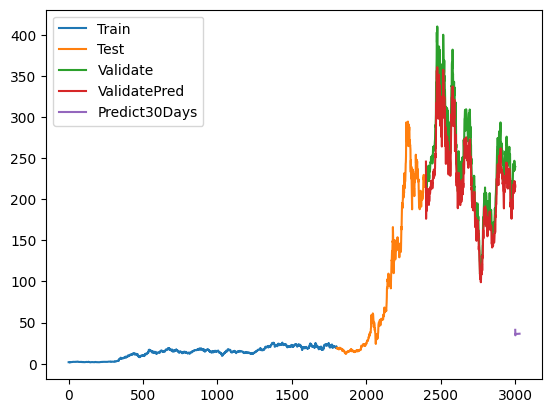

In [87]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(val_data.index,val_data['Close'])
plt.plot(val_data.index,y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Validate','ValidatePred','Predict30Days'])
plt.show()